In [2]:
import geopandas as gpd
import networkx as nx
import pandas as pd
import tempun
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from celluloid import Camera
import random
import geopandas as gpd
from shapely.geometry import LineString, Point, MultiPoint

import google_conf

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

from IPython.display import HTML
#result = pyreadr.read_r('/path/to/file.Rds')


In [3]:
plt.style.use('seaborn-white')
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"

def save_figure(fig, fig_name):
    fig.savefig("../figures/" + fig_name + ".tiff")
    fig.savefig("../figures/" + fig_name + ".png")

/var/folders/zg/zvg9y3rs7j527jxfq9sc2xqc0000gn/T/ipykernel_30433/3759009747.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [4]:
provinces = gpd.read_file("../data/roman_province_boundaries.json") # province file from "https://edh.ub.uni-heidelberg.de/data/download/roman_province_boundaries.json"
# however, there are invalid geometries... the following solution is based on advice from ChatGPT...
invalid_geometries = provinces[~provinces.geometry.is_valid]
# Make invalid geometries valid by buffering with a distance of 0
provinces.loc[~provinces.geometry.is_valid, 'geometry'] = invalid_geometries.buffer(0)
provinces = provinces.to_crs(3035)
# provinces.to_file("../data/provinces_valid.geojson")
#provinces = gpd.read_file("../data/provinces_valid.geojson")
provinces = provinces.to_crs("EPSG:4326")#
len(provinces)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/pygeos/constructive.py:175: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


61

In [5]:
pleiades_regions_merged = provinces.unary_union

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/pygeos/set_operations.py:388: RuntimeWarning: invalid value encountered in unary_union
  result = lib.unary_union(collections, **kwargs)


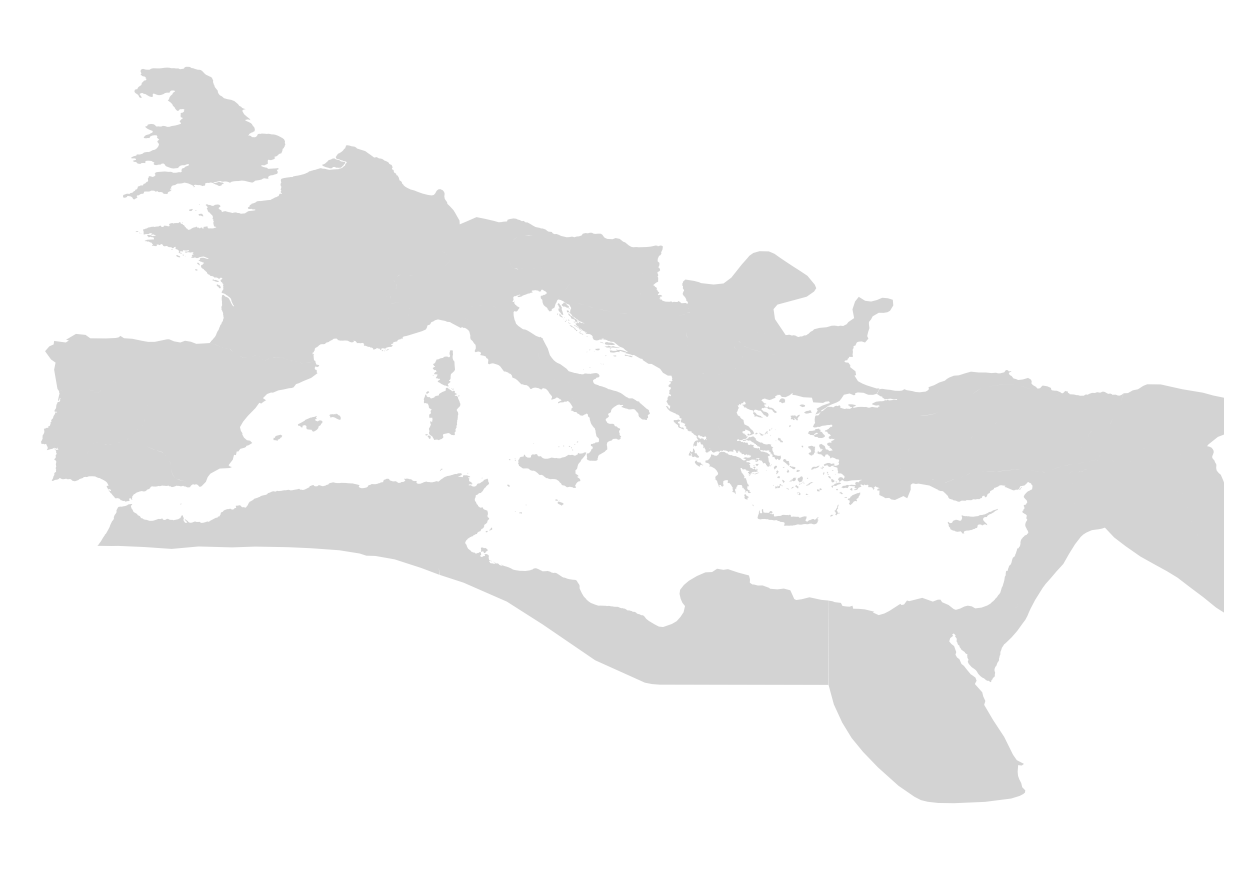

In [6]:
fig, ax = plt.subplots(figsize=(5.2, 3), dpi=300, tight_layout=True)
gpd.GeoSeries(pleiades_regions_merged).plot(ax=ax, color="lightgray")
#GIST.plot()
ax.set_xlim(-10, 45)
ax.set_axis_off()

In [7]:
# load the manually geocoded data
try:
    origo_sheet = google_conf.setup("https://docs.google.com/spreadsheets/d/17ibTaRJHHevY2wVsx9aK-NEd54fGho69l5dGJNE3XBA/edit?usp=sharing", service_account_path="../../ServiceAccountsKey.json")
    origo_df = google_conf.get_as_dataframe(origo_sheet.worksheet("2023WORKSHEET"))
except:
    origo_df = pd.read_csv("../data/origo_geocoded.csv")
                                            

In [9]:
origo_df = pd.read_csv("../data/origo_geocoded.csv")

In [8]:
#origo_df = pd.read_json("../data/origo_df.json")

In [10]:
origo_geo = origo_df[origo_df["pleiades_Latitude"].notnull() & origo_df["pleiades_Longitude"].notnull()] # we had 1723 last time
len(origo_geo)

2464

In [15]:
origo_geo["origo_point"] = origo_geo.apply(lambda row: Point(np.array([row["pleiades_Longitude"], row["pleiades_Latitude"]])), axis=1)
# origo_geo = gpd.GeoDataFrame(origo_geo.copy(), geometry=origo_geo["origo_point"])

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<Axes: >

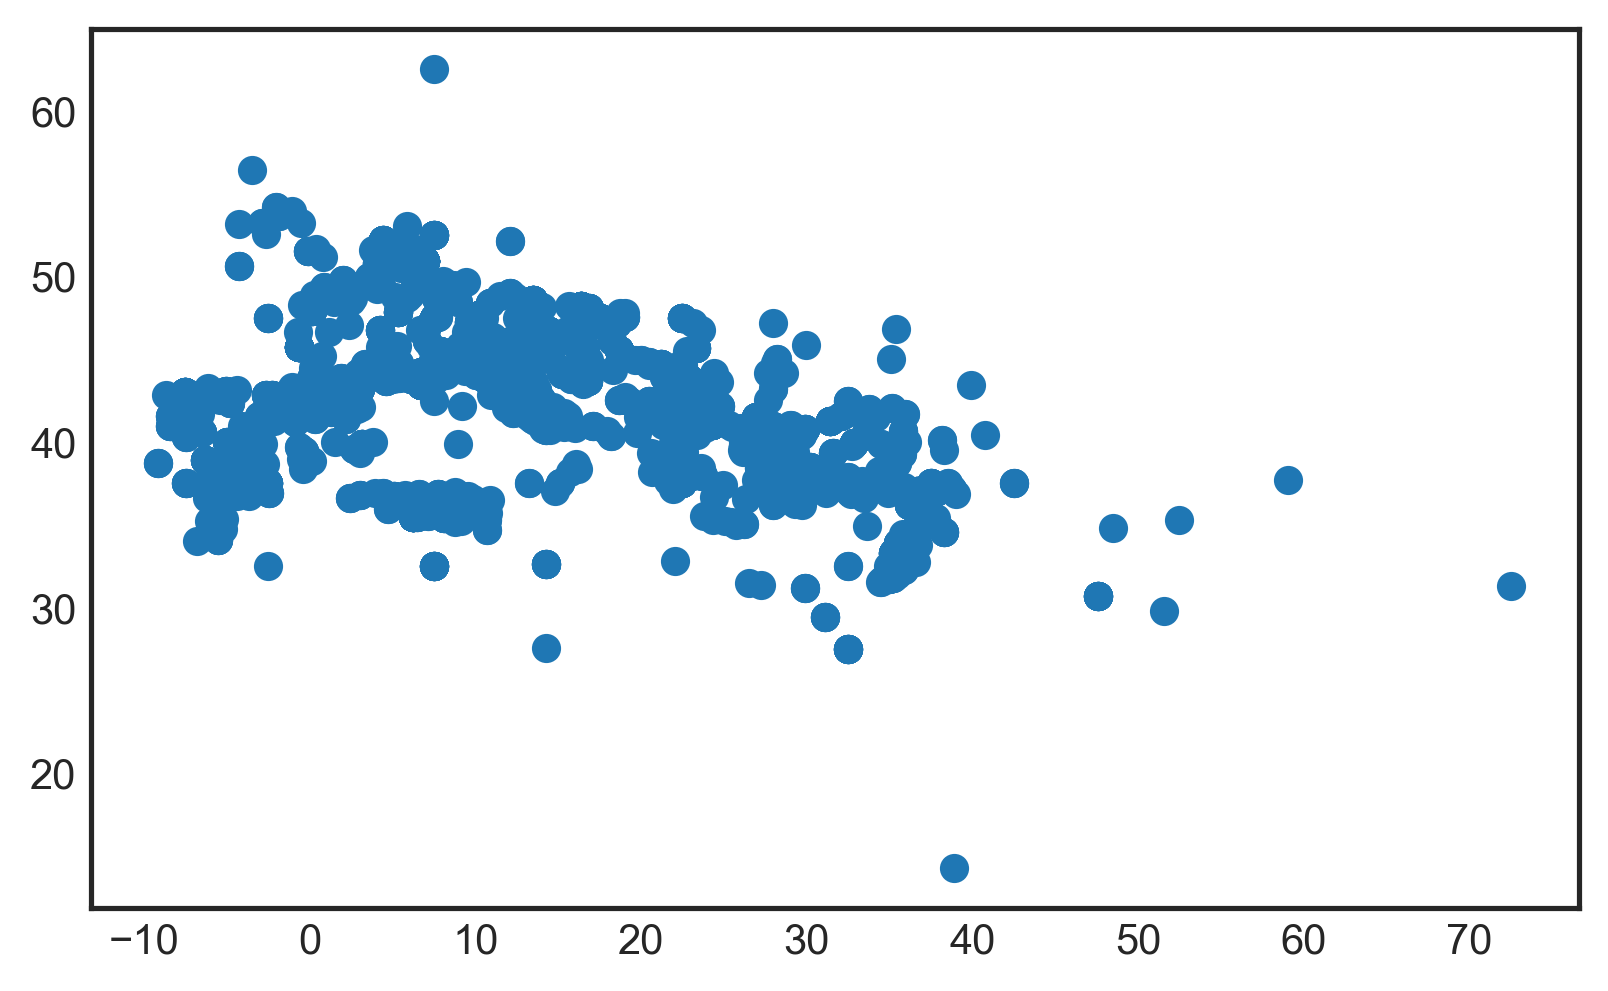

In [16]:
origo_geo.plot()

In [17]:
# we will need some other metadata from the inscriptions
# use your own dataset for EDH metadata
try:
    LIST = gpd.read_parquet("../../LI_ETL/data/large_data/LIST_v0-6.parquet")
except:
    LIST = gpd.read_parquet("https://zenodo.org/record/7993915/files/LIST_v0-5.parquet?download=1")

In [18]:
#LIST = LIST.rename(columns={"not_before" : "not_after", "not_after" : "not_before"})
LIST.head(5)

,LIST-ID,EDCS-ID,EDH-ID,trismegistos_uri,pleiades_id,transcription,inscription,clean_text_conservative,clean_text_interpretive_sentence,clean_text_interpretive_word,...,Longitude,Latitude,geotemporal?,geometry,withinRE?,urban_context,urban_context_city,urban_context_pop_est,type_of_inscription_auto,type_of_inscription_auto_prob
445463,445464,EDCS-24900077,HD056163,https://www.trismegistos.org/text/177366,570485,Q(uinto) Caecilio C(ai) f(ilio) Metelo / imper...,Q(uinto) Caecilio C(ai) f(ilio) Metel(l)o / im...,Q Caecilio C f Metelo imperatori Italici quei ...,Quinto Caecilio Cai filio Metelo imperatori It...,Quinto Caecilio Cai filio Metelo imperatori It...,...,22.841200,37.649800,True,POINT (22.841 37.650),True,rural,None,NaN,honorific inscription,1.0
445464,445465,EDCS-03700724,HD052964,https://www.trismegistos.org/text/121715,531064,Fortissimo et piis/simo Caesari d(omino) n(ost...,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et piissimo Caesari d n Gal Val P F...,Fortissimo et piissimo Caesari domino nostro G...,Fortissimo et piissimo Caesari domino nostro G...,...,20.766800,39.451200,True,POINT (20.767 39.451),True,rural,None,NaN,honorific inscription,1.0
445465,445466,EDCS-13800065,HD017714,https://www.trismegistos.org/text/177100,570049,Italicei / quei Aegei negotiantur / P(ublium) ...,Italicei / quei Aegei negotiantur / P(ublium) ...,Italicei quei Aegei negotiantur P Rutilium P f...,Italicei quei Aegei negotiantur Publium Rutili...,Italicei quei Aegei negotiantur Publium Rutili...,...,22.084500,38.248700,True,POINT (22.084 38.249),True,small,Aegium,1000.0,votive inscription,1.0
445466,445467,EDCS-03300852,HD051000,https://www.trismegistos.org/text/177273,240855,[Imp(eratori) Caes(ari) M(arco)] / An[nio] Flo...,Imp(eratori) / Floriano / P(io) F(elici) Aug(u...,An Floriano P F Aug p p m p III Imp Caes M Aur...,Imperatori Caesari Marco Annio Floriano Pio Fe...,Imperatori Caesari Marco Annio Floriano Pio Fe...,...,22.417100,37.431900,True,POINT (22.417 37.432),True,large,Tegea,46362.0,mile-/leaguestone,1.0
445467,445468,EDCS-28500283,HD021396,https://www.trismegistos.org/text/177131,,T[i(berius)] Claudius Caesar Aug(ustus) / G[er...,T[(iberius)] Claudius Caesar Aug(ustus) / G[er...,T Claudius Caesar Aug Ganicus pontif max trib ...,Tiberius Claudius Caesar Augustus Germanicus p...,Tiberius Claudius Caesar Augustus Germanicus p...,...,22.420877,37.454501,True,POINT (22.421 37.455),True,large,Tegea,46362.0,public legal inscription,1.0


In [19]:
len(LIST[LIST["EDH-ID"].isin(origo_geo["hd_nr"])])

1979

In [20]:
# list filtered to EDH only

LIST_edh= LIST[LIST["EDH-ID"].notnull()]
LIST_edh = LIST_edh[(LIST_edh["not_before"].notnull() | LIST_edh["not_after"].notnull())]

# assign random dates using tempun
LIST_edh["random_dates"] = LIST_edh.apply(lambda row: tempun.model_date(row["not_before"], row["not_after"], size=10, antepost=True),axis=1)
LIST_edh["random_date"] = LIST_edh["random_dates"].apply(lambda x: x[0])

In [21]:
LIST_edh

,LIST-ID,EDCS-ID,EDH-ID,trismegistos_uri,pleiades_id,transcription,inscription,clean_text_conservative,clean_text_interpretive_sentence,clean_text_interpretive_word,...,geotemporal?,geometry,withinRE?,urban_context,urban_context_city,urban_context_pop_est,type_of_inscription_auto,type_of_inscription_auto_prob,random_dates,random_date
445463,445464,EDCS-24900077,HD056163,https://www.trismegistos.org/text/177366,570485,Q(uinto) Caecilio C(ai) f(ilio) Metelo / imper...,Q(uinto) Caecilio C(ai) f(ilio) Metel(l)o / im...,Q Caecilio C f Metelo imperatori Italici quei ...,Quinto Caecilio Cai filio Metelo imperatori It...,Quinto Caecilio Cai filio Metelo imperatori It...,...,True,POINT (22.841 37.650),True,rural,None,NaN,honorific inscription,1.0,"[-68, -68, -68, -68, -68, -68, -68, -68, -68, ...",-68
445464,445465,EDCS-03700724,HD052964,https://www.trismegistos.org/text/121715,531064,Fortissimo et piis/simo Caesari d(omino) n(ost...,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et piissimo Caesari d n Gal Val P F...,Fortissimo et piissimo Caesari domino nostro G...,Fortissimo et piissimo Caesari domino nostro G...,...,True,POINT (20.767 39.451),True,rural,None,NaN,honorific inscription,1.0,"[311, 309, 312, 312, 312, 311, 310, 311, 310, ...",311
445465,445466,EDCS-13800065,HD017714,https://www.trismegistos.org/text/177100,570049,Italicei / quei Aegei negotiantur / P(ublium) ...,Italicei / quei Aegei negotiantur / P(ublium) ...,Italicei quei Aegei negotiantur P Rutilium P f...,Italicei quei Aegei negotiantur Publium Rutili...,Italicei quei Aegei negotiantur Publium Rutili...,...,True,POINT (22.084 38.249),True,small,Aegium,1000.0,votive inscription,1.0,"[-74, -74, -74, -74, -74, -74, -74, -74, -74, ...",-74
445466,445467,EDCS-03300852,HD051000,https://www.trismegistos.org/text/177273,240855,[Imp(eratori) Caes(ari) M(arco)] / An[nio] Flo...,Imp(eratori) / Floriano / P(io) F(elici) Aug(u...,An Floriano P F Aug p p m p III Imp Caes M Aur...,Imperatori Caesari Marco Annio Floriano Pio Fe...,Imperatori Caesari Marco Annio Floriano Pio Fe...,...,True,POINT (22.417 37.432),True,large,Tegea,46362.0,mile-/leaguestone,1.0,"[279, 279, 277, 278, 276, 276, 281, 278, 278, ...",279
445467,445468,EDCS-28500283,HD021396,https://www.trismegistos.org/text/177131,,T[i(berius)] Claudius Caesar Aug(ustus) / G[er...,T[(iberius)] Claudius Caesar Aug(ustus) / G[er...,T Claudius Caesar Aug Ganicus pontif max trib ...,Tiberius Claudius Caesar Augustus Germanicus p...,Tiberius Claudius Caesar Augustus Germanicus p...,...,True,POINT (22.421 37.455),True,large,Tegea,46362.0,public legal inscription,1.0,"[50, 50, 50, 49, 49, 49, 50, 50, 50, 49]",50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525865,525866,None,HD082771,None,207361,------] /[--- vixit an]nis / [--- Ger?]man/[us...,None,nis man ex arioV,vixit annis Germanus veteranus ex cohortis sag...,vixit annis Germanus veteranus ex cohortis sag...,...,True,POINT (23.158 47.180),True,rural,None,NaN,epitaph,1.0,"[257, 208, 263, 224, 202, 203, 208, 215, 209, ...",257
525866,525867,None,HD082808,None,207304,Silvan/o Dom(estico) / Aureli(us) / Annia/nus ...,None,Silvano Dom Aureli Annianus pr,Silvano Domestico Aurelius Annianus pr,Silvano Domestico Aurelius Annianus pr,...,True,POINT (23.590 46.772),True,medium,Napoca,5399.0,votive inscription,1.0,"[203, 220, 209, 240, 197, 190, 180, 197, 185, ...",203
525867,525868,None,HD082809,https://www.trismegistos.org/text/705780,187583,[Dis] / Maiorib(us) / [T]urboni/[u]s [---] / [...,None,Maiorib urbonis Tur,Dis Maioribus Turbonius et Turboni,Dis Maioribus Turbonius et Turboni,...,True,POINT (13.565 47.246),True,rural,None,NaN,votive inscription,1.0,"[294, 214, 213, 211, 124, 162, 229, 283, 258, ...",294
525868,525869,None,HD082812,None,197273,MISALIV[---],None,MISALIV,MISALIV,MISALIV,...,True,POINT (15.989 47.345),True,rural,None,NaN,building/dedicatory inscription,1.0,"[147, 126, 171, 183, 107, 140, 108, 136, 143, ...

In [22]:
# map EDH metadata on origo_geo dataset
edh_geo_dict = dict(zip(LIST_edh["EDH-ID"], LIST_edh["geometry"]))
edh_date_dict = dict(zip(LIST_edh["EDH-ID"], LIST_edh["random_date"]))
edh_notbefore_dict = dict(zip(LIST_edh["EDH-ID"], LIST_edh["not_before"]))
edh_notafter_dict = dict(zip(LIST_edh["EDH-ID"], LIST_edh["not_after"]))

def get_val_from_dict(x, data_dict):
    try:
        return data_dict[x]
    except:
        return None
origo_geo["edh_point"] = origo_geo["hd_nr"].apply(lambda x: get_val_from_dict(x, edh_geo_dict))
origo_geo["random_date"] = origo_geo["hd_nr"].apply(lambda x: get_val_from_dict(x, edh_date_dict))

origo_geo["not_before"] = origo_geo["hd_nr"].apply(lambda x: get_val_from_dict(x, edh_notbefore_dict))
origo_geo["not_after"] = origo_geo["hd_nr"].apply(lambda x: get_val_from_dict(x, edh_notafter_dict))

In [48]:
#remove rows with missing edh findspot geometry
origo_geo = origo_geo[~gpd.GeoSeries(origo_geo["edh_point"]).is_empty]

In [49]:
origo_geo = origo_geo[(origo_geo["random_date"].notnull()) & (origo_geo["origo_point"].notnull()) & (origo_geo["edh_point"].notnull())]
len(origo_geo)

2277

In [50]:
len(set(origo_geo["hd_nr"]))

1951

# Simple lines

In [51]:
origo_geo["origo_line"] = origo_geo.apply(lambda row: LineString([row["origo_point"], row["edh_point"]]), axis=1)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<Axes: >

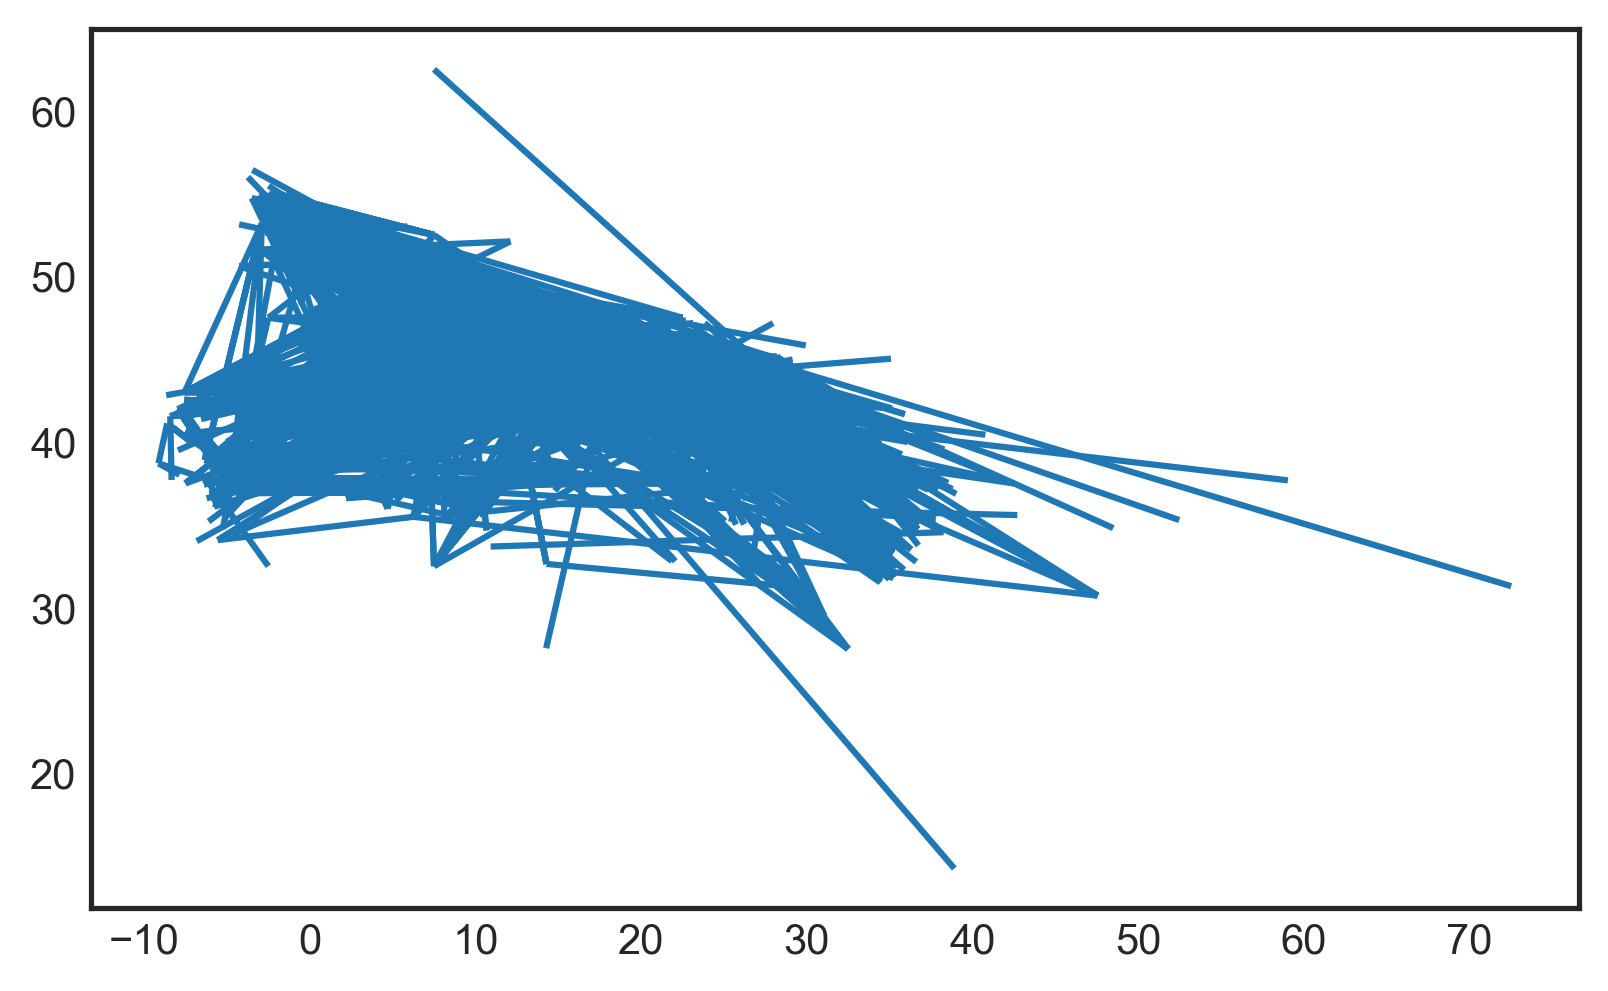

In [52]:
origo_geo.set_geometry('origo_line').plot()

In [53]:
origo_geo.set_geometry('origo_line', inplace=True)

In [37]:
origo_geo["random_date"] = origo_geo["random_date"].astype(int)

In [55]:
origo_geo.to_pickle("../data/origo_geo.pickle")